## 深度学习进行文本分类

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
## 设置字体
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "/Library/Fonts/华文细黑.ttf",size=14)

### 数据与处理阶段，文本分词去除停用词，并使用空格连接每一个词

使用THUCNews的一个子集进行训练与测试，本次训练使用了其中的10个分类，每个分类6500条数据。

数据集划分如下：

训练集: 5000\*10

验证集: 500\*10

测试集: 1000\*10

每个数据集有4列数据，分别为类别标签、新闻文本、分词后使用空格隔开的词组、每个文本分词词组的个数

In [3]:
## 读取测数据集
train_df = pd.read_csv("/Users/daitu/慕课/Python机器学习入门/data/cnews/cnews_train.csv")
val_df = pd.read_csv("/Users/daitu/慕课/Python机器学习入门/data/cnews/cnews_val.csv")
test_df = pd.read_csv("/Users/daitu/慕课/Python机器学习入门/data/cnews/cnews_test.csv")
train_df.head()

,label,text,cutword,cutwordnum
0,体育,马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有...,马晓旭 意外 受伤 国奥 警惕 无奈 大雨 格外 青睐 殷家 记者 傅亚雨 沈阳 报道 来到...,259
1,体育,商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也...,商瑞华 首战 复仇 心切 中国 玫瑰 美国 方式 攻克 瑞典 多曼来 瑞典 商瑞华 首战 信...,526
2,体育,冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新...,冠军 球队 迎新 欢乐 派对 黄旭获 大奖 张军 PK 新浪 体育讯 12 27 日晚 冠军...,610
3,体育,辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波...,辽足 签约 危机 注册 难关 高层 威逼利诱 合同 笑里藏刀 新浪 体育讯 24 辽足 爆发...,524
4,体育,揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道 谢亚龙已经被公安...,揭秘 谢亚龙 带走 总局 电话 骗局 复制 南杨 轨迹 体坛周报 特约记者 张锐 北京 报道...,282


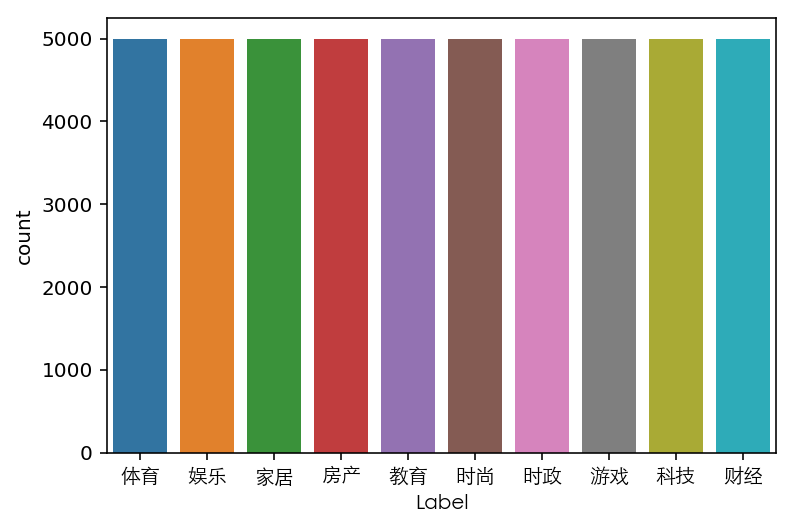

In [4]:
## 查看训练集都有哪些标签
plt.figure()
sns.countplot(train_df.label)
plt.xlabel('Label',fontproperties = fonts,size = 10)
plt.xticks(fontproperties = fonts,size = 10)
plt.show()

**可以发现数据集包括体育、娱乐、家居、房产、教育、教育、时尚、时政、游戏、科技、财经**

count    50000.000000
mean       300.462240
std        304.555855
min          4.000000
25%        115.000000
50%        226.000000
75%        382.000000
max       9083.000000
Name: cutwordnum, dtype: float64


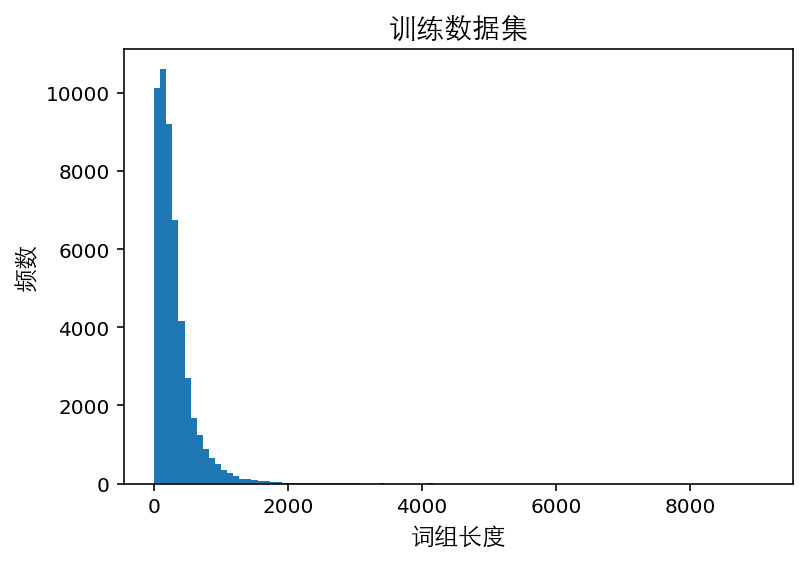

In [5]:
## 分析训练集中词组数量的分布
print(train_df.cutwordnum.describe())
plt.figure()
plt.hist(train_df.cutwordnum,bins=100)
plt.xlabel("词组长度",fontproperties = fonts,size = 12)
plt.ylabel("频数",fontproperties = fonts,size = 12)
plt.title("训练数据集",fontproperties = fonts)
plt.show()

**可以发现自小长度的词组长为4，最大长度为9083，其中长度的平均数为300，长度的中位数为226.**

In [6]:
## 对数据集的标签数据进行编码
train_y = train_df.label
val_y = val_df.label
test_y = test_df.label
le = LabelEncoder()
train_y = le.fit_transform(train_y).reshape(-1,1)
val_y = le.transform(val_y).reshape(-1,1)
test_y = le.transform(test_y).reshape(-1,1)

## 对数据集的标签数据进行one-hot编码
ohe = OneHotEncoder()
train_y = ohe.fit_transform(train_y).toarray()
val_y = ohe.transform(val_y).toarray()
test_y = ohe.transform(test_y).toarray()

In [8]:
test_y

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [9]:
## 使用Tokenizer对词组进行编码
## 当我们创建了一个Tokenizer对象后，使用该对象的fit_on_texts()函数，以空格去识别每个词,
## 可以将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小。
max_words = 5000
max_len = 600
tok = Tokenizer(num_words=max_words)  ## 使用的最大词语数为5000
tok.fit_on_texts(train_df.cutword)

In [37]:
## 使用word_index属性可以看到每次词对应的编码
## 使用word_counts属性可以看到每个词对应的频数
for ii,iterm in enumerate(tok.word_index.items()):
    if ii < 10:
        print(iterm)
    else:
        break
print("===================")  
for ii,iterm in enumerate(tok.word_counts.items()):
    if ii < 10:
        print(iterm)
    else:
        break

('我们', 1)
('一个', 2)
('中国', 3)
('可以', 4)
('基金', 5)
('没有', 6)
('自己', 7)
('他们', 8)
('市场', 9)
('这个', 10)
('马晓旭', 2)
('意外', 1641)
('受伤', 1948)
('国奥', 148)
('警惕', 385)
('无奈', 1161)
('大雨', 77)
('格外', 529)
('青睐', 1092)
('殷家', 1)


In [11]:
## 对每个词编码之后，每句新闻中的每个词就可以用对应的编码表示，即每条新闻可以转变成一个向量了：
train_seq = tok.texts_to_sequences(train_df.cutword)
val_seq = tok.texts_to_sequences(val_df.cutword)
test_seq = tok.texts_to_sequences(test_df.cutword)
## 将每个序列调整为相同的长度
train_seq_mat = sequence.pad_sequences(train_seq,maxlen=max_len)
val_seq_mat = sequence.pad_sequences(val_seq,maxlen=max_len)
test_seq_mat = sequence.pad_sequences(test_seq,maxlen=max_len)

In [12]:
print(train_seq_mat.shape)
print(val_seq_mat.shape)
print(test_seq_mat.shape)

(50000, 600)
(5000, 600)
(10000, 600)


In [18]:
# ## 定义LSTM模型
# inputs = Input(name='inputs',shape=[max_len])
# ## Embedding(词汇表大小,batch大小,每个新闻的词长)
# layer = Embedding(max_words+1,128,input_length=max_len)(inputs)
# layer = Conv1D(250, 3, padding='valid', activation='relu', strides=1)(layer)
# layer = MaxPooling1D(3)(layer)
# layer = Flatten()(layer)
# layer = Dense(128,activation="relu",name="FC1")(layer)
# layer = Dropout(0.5)(layer)
# layer = Dense(10,activation="softmax",name="FC2")(layer)
# model = Model(inputs=inputs,outputs=layer)
# model.summary()
# model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])

In [15]:
## 定义LSTM模型
inputs = Input(name='inputs',shape=[max_len])
## Embedding(词汇表大小,batch大小,每个新闻的词长)
layer = Embedding(max_words+1,128,input_length=max_len)(inputs)
layer = LSTM(128)(layer)
layer = Dense(128,activation="relu",name="FC1")(layer)
layer = Dropout(0.5)(layer)
layer = Dense(10,activation="softmax",name="FC2")(layer)
model = Model(inputs=inputs,outputs=layer)
model.summary()
model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 600)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 600, 128)          640128    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
FC1 (Dense)                  (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
FC2 (Dense)                  (None, 10)                1290      
Total params: 789,514
Trainable params: 789,514
Non-trainable params: 0
_________________________________________________________________


In [17]:
## 模型训练
model_fit = model.fit(train_seq_mat,train_y,batch_size=128,epochs=10,
                      validation_data=(val_seq_mat,val_y),
                      callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)] ## 当val-loss不再提升时停止训练
                     )

Train on 50000 samples, validate on 5000 samples
Epoch 1/10
50000/50000 [==============================] - 640s 13ms/step - loss: 0.2517 - acc: 0.9411 - val_loss: 0.3850 - val_acc: 0.9102
Epoch 2/10
50000/50000 [==============================] - 720s 14ms/step - loss: 0.1793 - acc: 0.9580 - val_loss: 0.3495 - val_acc: 0.9168
Epoch 3/10
50000/50000 [==============================] - 781s 16ms/step - loss: 0.1426 - acc: 0.9672 - val_loss: 0.3765 - val_acc: 0.9058


In [19]:
## 对测试集进行预测
test_pre = model.predict(test_seq_mat)

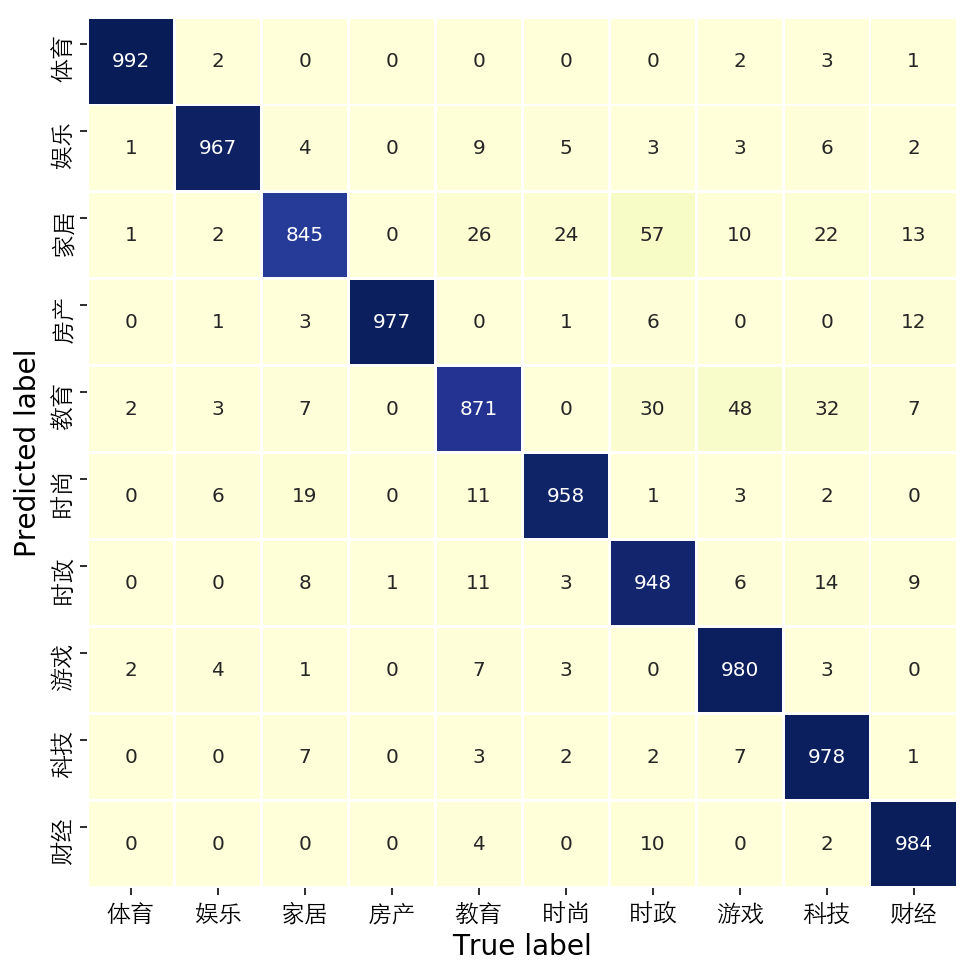

In [39]:
## 评价预测效果，计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1))
## 混淆矩阵可视化
Labname = ["体育","娱乐","家居","房产","教育","时尚","时政","游戏","科技","财经"]
plt.figure(figsize=(8,8))
sns.heatmap(confm.T, square=True, annot=True,
            fmt='d', cbar=False,linewidths=.8,
            cmap="YlGnBu")
plt.xlabel('True label',size = 14)
plt.ylabel('Predicted label',size = 14)
plt.xticks(np.arange(10)+0.5,Labname,fontproperties = fonts,size = 12)
plt.yticks(np.arange(10)+0.3,Labname,fontproperties = fonts,size = 12)
plt.show()

In [25]:
print(metrics.classification_report(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1)))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       998
          1       0.97      0.98      0.97       985
          2       0.84      0.95      0.89       894
          3       0.98      1.00      0.99       978
          4       0.87      0.92      0.90       942
          5       0.96      0.96      0.96       996
          6       0.95      0.90      0.92      1057
          7       0.98      0.93      0.95      1059
          8       0.98      0.92      0.95      1062
          9       0.98      0.96      0.97      1029

avg / total       0.95      0.95      0.95     10000

